In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Simulate 250 days of daily returns for 3 assets

In [105]:
portfolio_value = 10_000_000

np.random.seed(42)
returns = pd.DataFrame({
    'Bond':   np.random.normal(-0.0002, 0.008, 250),   # 0.8% daily vol with light negative drift
    'FX':     np.random.normal(0.0000, 0.015, 250),  # Slight downward drift + higher vol
    'Equity': np.random.normal(0.0004, 0.02, 250)    # 2% daily vol
})

# And don't forget to define the weights as well
weights = [0.4, 0.3, 0.3]

# Historical, Conditional, Stressed VaR computation

In [107]:
# Historical
def compute_historical_var(returns, confidence=0.99):
    portfolio_returns = returns @ weights
    var = -np.percentile(portfolio_returns, (1 - confidence) * 100)
    return portfolio_returns, var

In [108]:
#Conditional VaR (Expected Shortfall)
def compute_expected_shortfall(portfolio_returns, confidence=0.99):
    var_threshold = np.percentile(portfolio_returns, (1 - confidence) * 100)
    tail_losses = portfolio_returns[portfolio_returns <= var_threshold]
    es = -tail_losses.mean()
    return es

In [109]:
# Stressed VaR (using worst 60-day period)
def compute_stressed_var(returns, confidence=0.99, window=60):
    portfolio_returns = returns @ weights
    rolling_var = portfolio_returns.rolling(window).apply(
        lambda x: -np.percentile(x, (1 - confidence) * 100), raw=True
    )
    stressed_var = rolling_var.max()  # Worst-case historical VaR
    return stressed_var

# Plot a layered return distribution

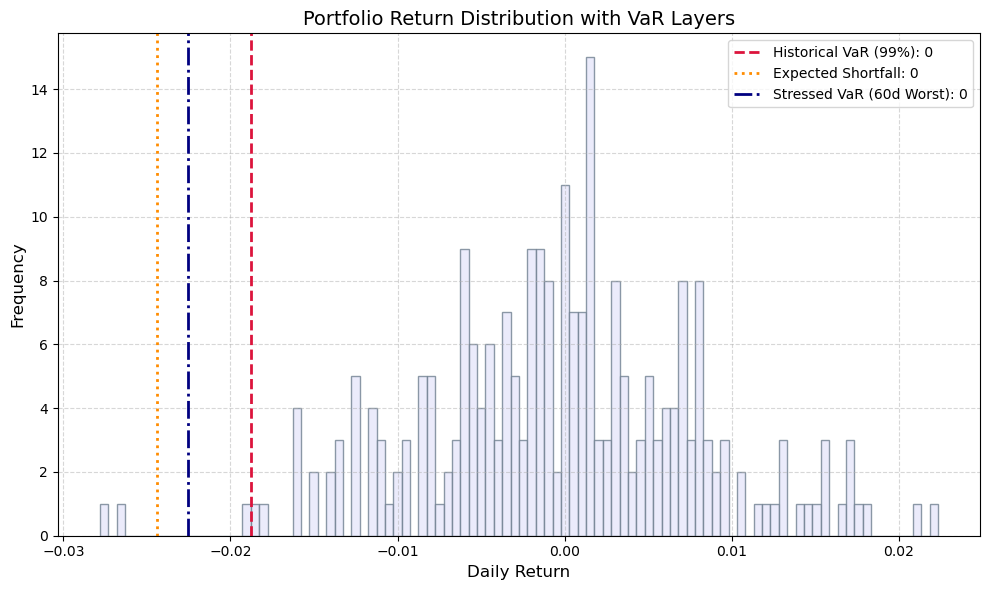

In [111]:
# Generate or reuse daily portfolio returns
portfolio_returns, hist_var = compute_historical_var(returns)
es = compute_expected_shortfall(portfolio_returns)
stressed_var = compute_stressed_var(returns)

plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=100, color='lavender', edgecolor='slategray', alpha=0.8)

# Overlay lines for each layer
plt.axvline(-hist_var, color='crimson', linestyle='--', linewidth=2, label=f'Historical VaR (99%): {hist_var:,.0f}')
plt.axvline(-es, color='darkorange', linestyle=':', linewidth=2, label=f'Expected Shortfall: {es:,.0f}')
plt.axvline(-stressed_var, color='navy', linestyle='-.', linewidth=2, label=f'Stressed VaR (60d Worst): {stressed_var:,.0f}')

plt.title('Portfolio Return Distribution with VaR Layers', fontsize=14)
plt.xlabel('Daily Return', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("Portfolio Return Distribution with VaR Layers.png", dpi=300)
plt.show()

In [121]:
pd.DataFrame({
    'Metric': ['Historical VaR (99%)', 'Expected Shortfall', 'Stressed VaR (60-day Worst)'],
    'Value (USD)': [hist_var, es, stressed_var]
})

,Metric,Value (USD)
0,Historical VaR (99%),0.018757
1,Expected Shortfall,0.024406
2,Stressed VaR (60-day Worst),0.022526
